In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

In [3]:
df = pd.concat([train_df, test_df], axis=0)

In [4]:
def preprocess_data(df):
    # Convert date to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Extract features from datetime
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    
    # One-hot encode categorical variables
    categorical_cols = ['category', 'gender']
    df = pd.get_dummies(df, columns=categorical_cols)
    
    # Drop unnecessary columns
    cols_to_drop = ['trans_date_trans_time', 'merchant', 'first', 'last', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'unix_time']
    df = df.drop(columns=cols_to_drop)
    
    return df

df_processed = preprocess_data(df)

In [5]:
X = df_processed.drop('is_fraud', axis=1)
y = df_processed['is_fraud']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)


C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 493, in run
    with Pope

KMeans(n_clusters=2, random_state=42)

In [9]:
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)


In [10]:
if np.sum(train_clusters == 0) < np.sum(train_clusters == 1):
    fraud_cluster = 0
else:
    fraud_cluster = 1

y_pred = (test_clusters == fraud_cluster).astype(int)


In [15]:
train_pred = (kmeans.labels_ == fraud_cluster).astype(int)
train_accuracy = accuracy_score(y_train, train_pred)

# Calculate testing accuracy
test_pred = (kmeans.predict(X_test_scaled) == fraud_cluster).astype(int)
test_accuracy = accuracy_score(y_test, test_pred)

In [16]:


print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score: {roc_auc_score(y_test, y_pred):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_pred):.4f}")


Training Accuracy: 0.5473
Testing Accuracy: 0.5493
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71    368549
           1       0.01      0.50      0.01      1930

    accuracy                           0.55    370479
   macro avg       0.50      0.52      0.36    370479
weighted avg       0.99      0.55      0.70    370479


Confusion Matrix:
[[202528 166021]
 [   965    965]]

AUC-ROC Score: 0.5248
Average Precision Score: 0.0055


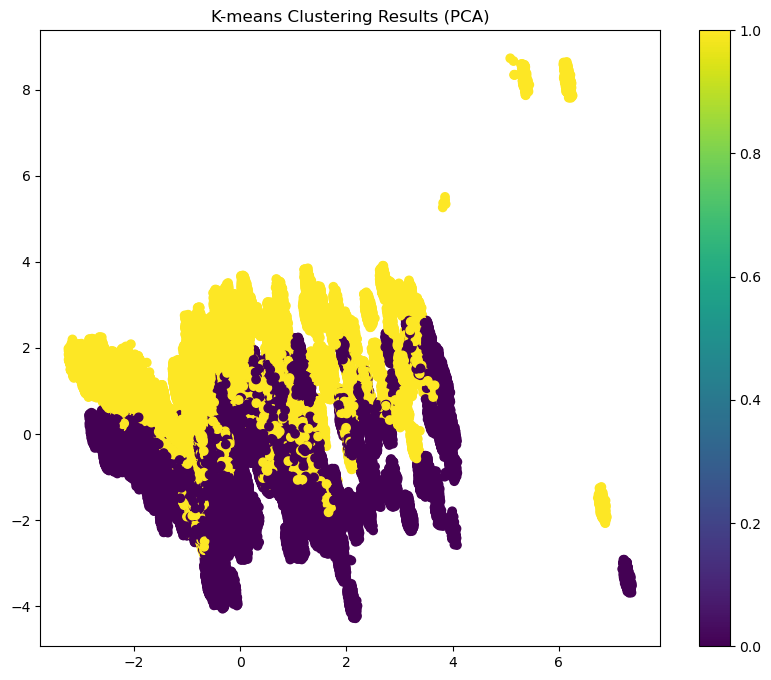

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_clusters, cmap='viridis')
plt.title('K-means Clustering Results (PCA)')
plt.colorbar(scatter)
plt.show()

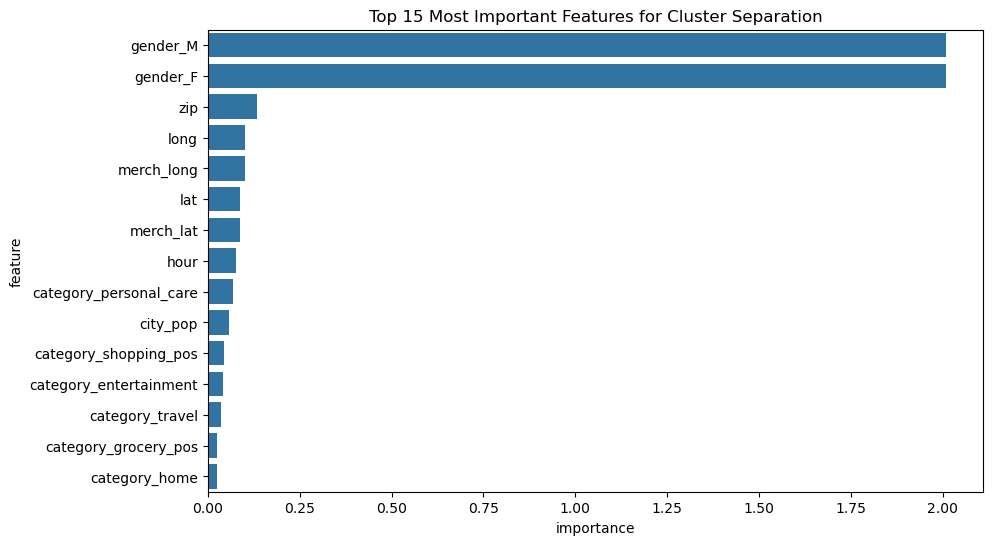

In [13]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(kmeans.cluster_centers_[fraud_cluster] - kmeans.cluster_centers_[1-fraud_cluster])
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features for Cluster Separation')
plt.show()